In [155]:
import pandas as pd
import numpy as np
import os
import pickle
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('seaborn-notebook')

%matplotlib inline

pd.set_option('display.max_columns', 20)

## Data Sources
There are two similar yet slightly different sources for this data. The 2000 data comes from the Decennial United States Census whereas the 2009-2016 data comes from American Community Survey 5-year estimates. Both data sources contain roughly the same features, format, and geographic contraints (census tracts). 

In [2]:
#system agnostic data path
raw_data_dir = os.path.join(os.getcwd(), '..', 'data', 'raw')
#empty dict to hold all the variables, this will come in handy later
empty_vars = {'income': '', 'education': '', 'race': '',
              'rent': '', 'value': '', 'unemployment': ''}
#these are the data variable names for the decennial census
dec_data_vars = {'P052': 'income', 'QTP20': 'education', 'P007': 'race',
                 'H062': 'rent', 'H084': 'value', 'QTP24': 'unemployment'}
#these are the data variable names for the ACS 5-year estimates
acs_data_vars = {'B19001': 'income', 'S1501': 'education', 'B02001': 'race',
                 'B25063': 'rent', 'B25075': 'value', 'S2301': 'unemployment'}
#this will hold all the different file names to make reading data easier
data_dict = {
    '2000': empty_vars.copy(),
    '2009': empty_vars.copy(),
    '2010': empty_vars.copy(),
    '2011': empty_vars.copy(),
    '2012': empty_vars.copy(),
    '2013': empty_vars.copy(),
    '2014': empty_vars.copy(),
    '2015': empty_vars.copy(),
    '2016': empty_vars.copy()
}
#loop through raw data files (csv only) and assign each one to proper key
for fil in os.listdir(raw_data_dir):
    if fil.endswith('.csv'):
        fil_spl = fil.split('_')
        if fil_spl[3] in acs_data_vars.keys():
            data_dict['20'+fil_spl[1]][acs_data_vars[fil_spl[3]]] = os.path.join(raw_data_dir, fil)
        elif fil_spl[3] in dec_data_vars.keys():
            data_dict['20'+fil_spl[1]][dec_data_vars[fil_spl[3]]] = os.path.join(raw_data_dir, fil)
        else:
            print('Unexpected file not processed: {}'.format(fil))

Unexpected file not processed: ACS_09_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_15_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_11_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_12_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_16_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_10_5YR_B11001_with_ann.csv
Unexpected file not processed: ACS_14_5YR_B11001_with_ann.csv
Unexpected file not processed: DEC_00_SF4_QTP10_with_ann.csv
Unexpected file not processed: ACS_13_5YR_B11001_with_ann.csv


## Relating 2000 and 2010 Census Tracts
One complication that arises while working with census data is that tracts change over time as population changes. Tracts generally encompass a population between 2,500 and 8,000 people and are the intended to be a rough equivalent of a neighborhood. As the population grows, shrinks, and moves, some census tracts are split into smaller tracts while others are merged to form a new tract. This is the case between the 2000-2009 data, which use the 2000 census tracts, vs the 2010-2016 data, which use the 2010 census tracts. 

Thankfully, the Census Bureau tracks this sort of change very carefully and presents the morphology of census tracts in a detailed relationship file.

In [3]:
geoid_2000 = pd.read_csv(data_dict['2000']['income'], skiprows=1)['Id2']
geoid_2010 = pd.read_csv(data_dict['2016']['income'], skiprows=1)['Id2']

removed = list(set(geoid_2000) - set(geoid_2010))
added = list(set(geoid_2010) - set(geoid_2000))

tract_relations = pd.read_csv(os.path.join(os.getcwd(), '..', 'shapefiles', 'census_tract_relation_file.csv'),
                              usecols=[1, 3, 12, 25, 26])
tract_relations = tract_relations[tract_relations['county00'].isin([21, 55, 209, 453, 491])]

need_to_change = tract_relations[tract_relations['geoid00'].isin(removed)]
need_to_change = need_to_change[need_to_change['geoid10'].isin(added)]
need_to_change = need_to_change[need_to_change['poppct00'] > 0]
need_to_change = need_to_change[need_to_change['poppct10'] > 1]

need_to_change.to_csv(os.path.join(os.getcwd(), '..', 'shapefiles', 'need_to_change.csv'))

merged = need_to_change[(need_to_change['poppct00'] > 95) & (need_to_change['poppct10'] < 100)]
split = need_to_change[need_to_change['poppct10'] > 95]

In [4]:
def fix_tracts(df):
    #the tract for austin-bergstrom airport is missing from 2000 and 2009
    #there's no population or housing units in the tract (geoid: 48453980000)
    #so it can be filled in with zeros
    df.loc[48453980000] = 0
    #merged
    for geoid in merged['geoid10']:
        df.loc[geoid] = df.loc[list(merged['geoid00'])].sum()
    df.drop(list(merged['geoid00']), inplace=True)
    #split
    for row in split.iterrows():
        df.loc[row[1]['geoid10']] = round(df.loc[row[1]['geoid00']] * row[1]['poppct00'] / 100, 0)
    df.drop(list(split['geoid00'].unique()), inplace=True)
    df.astype('int')
    
    return df

In [5]:
def read_income(year):
    if year == '2000':
        usecols = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
                   12, 13, 14, 15, 16, 17, 18, 19]
    else:
        usecols=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19,
                 21, 23, 25, 27, 29, 31, 33, 35]
    income = pd.read_csv(data_dict[year]['income'], skiprows=1, usecols=usecols)
    income.index = income.pop('Id2')
    income.index.name = 'geoid'
    income.columns = ['total', '<10k', '[10k-15k)', '[15k-20k)',
                      '[20k-25k)', '[25k-30k)', '[30k-35k)', '[35k-40k)', '[40k-45k)',
                      '[45k-50k)', '[50k-60k)', '[60k-75k)', '[75k-100k)', '[100k-125k)',
                      '[125k-150k)', '[150k-200k)', '>200k']
    if year in ['2000', '2009']:
        income = fix_tracts(income)
    
    return income

In [6]:
def read_education(year):
    if year == '2000':
        usecols = [3, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53]
    elif year in ['2009', '2010', '2011', '2012', '2013']:
        usecols = [1, 33, 39, 45, 51, 57, 63, 69, 75]
    elif year == '2014':
        usecols = [1, 8, 9, 10, 11, 12, 13, 14, 15]
    else:
        usecols = [1, 13, 15, 17, 19, 21, 23, 25, 27]
    
    education = pd.read_csv(data_dict[year]['education'], skiprows=1, usecols=usecols, na_values=['-'])
    education.index = education.pop('Id2')
    education.index.name = 'geoid'
    
    if year == '2000':
        education.columns = ['total', '<5', '5-8', '9-12', 'high_school', 'some_college_1', 
                             'some_college_2', 'associate', 'bachelor', 'master', 
                             'professional', 'doctorate']
        education['<9'] = education.pop('<5') + education.pop('5-8')
        education['some_college'] = education.pop('some_college_1') + education.pop('some_college_2')
        education['graduate'] = education.pop('master') + education.pop('professional') \
                                + education.pop('doctorate')
        education = education[['total', '<9', '9-12', 'high_school', 'some_college',
                               'associate', 'bachelor', 'graduate']]
    
    elif year in ['2015', '2016']:
        education.columns = ['total', '<9', '9-12', 'high_school', 'some_college',
                             'associate', 'bachelor', 'graduate']
    
    else:
        education.columns = ['total', '<9', '9-12', 'high_school', 'some_college',
                             'associate', 'bachelor', 'graduate']
        education.fillna(0, inplace=True) #not actually missing - Austin-Bergrstrom Intl. Airport
        perc_cols = education.columns[1:]
        for c in perc_cols:
            education[c] = round(education[c] / 100 * education['total'], 0).astype('int')
        
    if year in ['2000', '2009']:
        education = fix_tracts(education)
        
    return education

In [7]:
def read_race(year):
    if year == '2000':
        usecols = [1, 3, 4]
    else:
        usecols = [1, 3, 5]
    race = pd.read_csv(data_dict[year]['race'], skiprows=1, usecols=usecols)
    race.index = race.pop('Id2')
    race.index.name = 'geoid'
    race.columns = ['total_population', 'white_alone']
    
    if year in ['2000', '2009']:
        race = fix_tracts(race)
        
    '''
    still need to convert to percent (here or next step?)
    '''
    
    return race

In [8]:
def read_families(year):
    if year == '2000':
        usecols = [3, 5, 7]
    else:
        usecols = [1, 3, 5]
    families = pd.read_csv(data_dict[year]['families'], skiprows=1, usecols=usecols)
    families.index = families.pop('Id2')
    families.index.name = 'geoid'
    families.columns = ['total_households', 'family_households']
    
    if year in ['2000', '2009']:
        families = fix_tracts(families)
        
    '''
    still need to convert to percent (here or next step?)
    '''
    
    return families

In [9]:
def read_rent(year):
    if year == '2000':
        usecols = [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
                   17, 18, 19, 20, 21, 22, 23, 24, 25]
    elif year in ['2009', '2010', '2011', '2012', '2013', '2014']:
        usecols = [1, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 
                   27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47]
    else:
        usecols=[1, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 
                 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
                 51, 53]
    rent = pd.read_csv(data_dict[year]['rent'], skiprows=1, usecols=usecols)
    rent.index = rent.pop('Id2')
    rent.index.name = 'geoid'
    if year in ['2015', '2016']:
        rent['>2000'] = rent[rent.columns[21:25]].sum(axis=1)
        rent.drop(rent.columns[[21, 22, 23, 24]], axis=1, inplace=True)
    
    rent.columns = ['total', '<100', '[100-150)', '[150-200)', '[200-250)',
                    '[250-300)', '[300-350)', '[350-400)', '[400-450)', '[450-500)', '[500-550)',
                    '[550-600)', '[600-650)', '[650-700)', '[700-750)', '[750-800)', '[800-900)',
                    '[900-1000)', '[1000-1250)', '[1250-1500)', '[1500-2000)', '>2000']
    
    if year in ['2000', '2009']:
        rent = fix_tracts(rent)
    
    return rent

In [10]:
def read_value(year):
    if year == '2000':
        usecols = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
                   16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
    elif year in ['2009', '2010', '2011', '2012', '2013', '2014']:
        usecols = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 
                   29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
    else:
        usecols = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 
                   29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55]
    
    value = pd.read_csv(data_dict[year]['value'], skiprows=1, usecols=usecols)
    value.index = value.pop('Id2')
    value.index.name = 'geoid'
    
    if year in ['2015', '2016']:
        value['>1M'] = value[value.columns[25:28]].sum(axis=1)
        value.drop(value.columns[[25, 26, 27]], axis=1, inplace=True)
    
    value.columns = ['total', '<10k', '[10k-15k)', '[15k-20k)', '[20k-25k)', 
                     '[25k-30k)', '[30k-35k)', '[35k-40k)', '[40k-50k)', '[50k-60k)', '[60k-70k)', 
                     '[70k-80k)', '[80k-90k)', '[90k-100k)', '[100k-125k)', '[125k-150k)', '[150k-175k)', 
                     '[175k-200k)', '[200k-250k)', '[250k-300k)', '[300k-400k)', '[400k-500k)', 
                     '[500k-750k)', '[750k-1M)', '>1M']
    
    if year in ['2000', '2009']:
        value = fix_tracts(value)
    
    return value

In [11]:
def read_unemployment(year):
    if year == '2000':
        usecols = [3, 5, 35]
    else:
        usecols = [1, 3, 9]
    unemployment = pd.read_csv(data_dict[year]['unemployment'], skiprows=1, usecols=usecols, na_values='-')
    unemployment.index = unemployment.pop('Id2')
    unemployment.index.name = 'geoid'
    unemployment.columns = ['total_in_labor_force', 'unemployed']
    if year != '2000':
        unemployment.fillna(0, inplace=True)
        unemployment['unemployed'] = round(unemployment['total_in_labor_force']\
                                           * unemployment['unemployed'] / 100, 0)
    
    if year in ['2000', '2009']:
        unemployment = fix_tracts(unemployment)
        
    return unemployment

In [12]:
all_data = {
    '2000': empty_vars.copy(),
    '2009': empty_vars.copy(),
    '2010': empty_vars.copy(),
    '2011': empty_vars.copy(),
    '2012': empty_vars.copy(),
    '2013': empty_vars.copy(),
    '2014': empty_vars.copy(),
    '2015': empty_vars.copy(),
    '2016': empty_vars.copy()
}

read_funs = [read_income, read_education, read_race,
             read_rent, read_value, read_unemployment]
read_vars = ['income', 'education', 'race', 
             'rent', 'value', 'unemployment']

for key in all_data.keys():
    for f, v in zip(read_funs, read_vars):
        all_data[key][v] = f(key)
        
pickle_all = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'all_data.pickle'), 'wb')
pickle.dump(all_data, pickle_all)

#All the data can now be read with the following two lines of code:
#pickle_in = open(os.path.join(os.getcwd(), '..', data', 'processed', 'all_data.pickle'), 'rb')
#data = pickle.load(pickle_in)

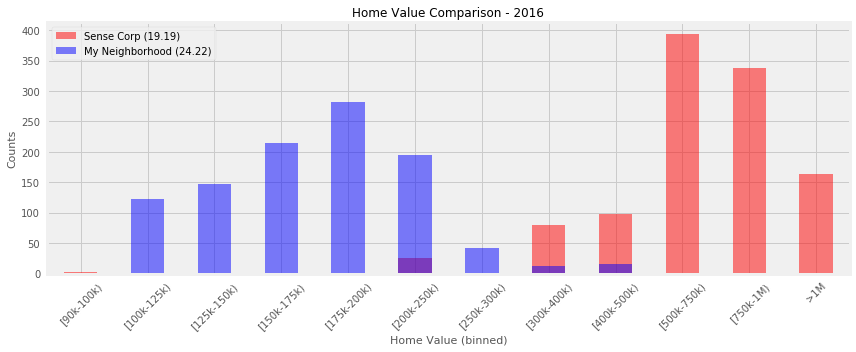

In [153]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))

all_data['2016']['value'].loc[48453001919, '[90k-100k)':].plot(kind='bar', 
                                                           ax=ax, 
                                                           color='red', 
                                                           alpha=0.5, 
                                                           label='Sense Corp (19.19)')
all_data['2016']['value'].loc[48453002422, '[90k-100k)':].plot(kind='bar', ax=ax, color='blue', 
                                                           alpha=0.5, label='My Neighborhood (24.22)')
_ = ax.legend(loc=2)
_ = plt.xticks(rotation=45)
_ = ax.set(xlabel='Home Value (binned)', ylabel='Counts',
           title='Home Value Comparison - 2016')
_ = fig.tight_layout()
_ = fig.savefig('../figures/home_value_comparison.png', dpi=500, transparent=True)

In [161]:
all_data['2016']['race'].head()

,total_population,white_alone
geoid,,
48021950100,8478,6974
48021950200,8365,5300
48021950300,14644,10666
48021950400,8707,7200
48021950501,8352,6949


## Transforming the data
Now we'll aggregate the binned data (rent, value, income, education) into indices, convert race and unemployment to percentages, as well as adjust each year for inflation.

In [160]:
#make a copy of all_data for transforming data 
#need to use copy.deepcopy() here so that the dataframes inside the dictionary are
#copied as well - if you just you all_data.copy(), the dictionary will be copied but
#the dataframes will share memory and any modifications to dataframes will be applied 
#the dataframes in all_data as well
trans_data = copy.deepcopy(all_data)
#the scorer for monetary variables is the middle value of the bin with an assumed
#value for the uppermost bin
income_scorer = np.array([5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5,
                          55, 67.5, 87.5, 112.5, 137.5, 175, 300]) * 1000
rent_scorer = np.array([50, 125, 175, 225, 275, 325, 375, 425, 475, 525, 575,
                        625, 675, 725, 775, 850, 950, 1125, 1375, 1750, 2500])
value_scorer = np.array([5, 12.5, 17.5, 22.5, 27.5, 32.5, 27.5, 45, 55, 65, 75, 
                         85, 95, 112.5, 137.5, 162.5, 187.5, 225, 275, 350, 450, 
                         625, 875, 1500]) * 1000
#education gets a simple 1-8 score
education_scorer = np.arange(1, 8)

#to adjust the values to 2016 dollars, the index are adjusted by the 
#yearly average consumer price index 
inflation_correction = np.array([1.39422697, 1.11865482, 1.10084296, 1.06686838,
                                 1.04536021, 1.03039158, 1.01380104, 1.01263642, 
                                 1.00000000])

for i,year in enumerate(trans_data.keys()):
    for key in trans_data[year].keys():
        tmp = trans_data[year][key]
        #bust out the total population from the race df
        if key == 'race':
            population = tmp['total_population'].to_frame()
        #bust out total in labor force from the unemployment df
        if key == 'unemployment':
            tmp['employed'] = tmp['total_in_labor_force'] - tmp['unemployed']
        #convert columns to percentages of total and drop the total column
        tmp = tmp[tmp.columns[1:]].divide(tmp[tmp.columns[0]], axis=0).fillna(0)
        #calculate the index (single number to represent binned data)
        if len(tmp.columns) > 1:
            if key == 'income':
                tmp['income_index'] = tmp.dot(income_scorer) * inflation_correction[i]
                display(tmp.head())
            elif key == 'rent':
                tmp['rent_index'] = tmp.dot(rent_scorer) * inflation_correction[i]
            elif key == 'value':
                tmp['value_index'] = tmp.dot(value_scorer) * inflation_correction[i]
            elif key == 'education':
                tmp['education_index'] = tmp.dot(education_scorer) 
        #put the new percentage column back into the dataframe
        trans_data[year][key] = tmp[tmp.columns[-1]].copy().to_frame()
    #concatenate the summary columns (1 for each dataframe) into a single dataframe
    trans_data[year] = pd.concat([trans_data[year][key] for key in trans_data[year].keys()], axis=1)
    #add a year column in the first position to be used later
    trans_data[year].insert(0, 'year', year)

,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.084983,0.029104,0.059759,0.088087,0.055103,0.034536,0.060147,0.067520,0.066744,0.115250,0.126504,0.133101,0.051610,0.007373,0.010865,0.009313,73599.981153
48021950200,0.139308,0.063809,0.066732,0.068680,0.058451,0.052606,0.077935,0.034584,0.048709,0.122747,0.114954,0.088164,0.014613,0.010716,0.019484,0.018509,67668.904461
48021950300,0.060980,0.038475,0.071869,0.051906,0.047550,0.079129,0.060617,0.060617,0.058076,0.091833,0.162250,0.096915,0.071869,0.016697,0.019964,0.011252,78678.935400
48021950400,0.094928,0.078261,0.046739,0.052536,0.056159,0.062319,0.066304,0.050000,0.043116,0.072464,0.159420,0.118116,0.047464,0.025000,0.012681,0.014493,75438.539903
48021950600,0.111628,0.079651,0.080814,0.050581,0.048837,0.073256,0.091279,0.053488,0.050000,0.069767,0.111047,0.093023,0.046512,0.010465,0.022093,0.007558,67172.153161


,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.072443,0.022017,0.026634,0.056818,0.074929,0.040128,0.048295,0.069957,0.041193,0.104403,0.116122,0.121449,0.121449,0.019886,0.040128,0.024148,75351.293642
48021950200,0.074928,0.076729,0.091499,0.015490,0.054395,0.042867,0.087176,0.054755,0.108790,0.069524,0.077089,0.098343,0.085375,0.037104,0.016571,0.009366,61508.888720
48021950300,0.052892,0.013949,0.049404,0.036036,0.029933,0.038361,0.031967,0.032258,0.049114,0.116536,0.141238,0.163615,0.136007,0.043011,0.024702,0.040976,86334.079417
48021950400,0.046069,0.089713,0.049879,0.034638,0.082092,0.025632,0.032560,0.072740,0.043298,0.074472,0.136474,0.136820,0.104260,0.021129,0.024247,0.025979,72057.722065
48021950600,0.087285,0.046048,0.041237,0.088660,0.039863,0.069416,0.065292,0.063230,0.061168,0.069416,0.099656,0.124399,0.090722,0.016495,0.025430,0.011684,63742.181779


,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.051868,0.007101,0.033344,0.106206,0.078728,0.035196,0.025316,0.041371,0.048472,0.110528,0.129978,0.123186,0.125965,0.029330,0.035196,0.018215,73865.916861
48021950200,0.060095,0.071455,0.058996,0.032613,0.075119,0.047636,0.071455,0.065592,0.072188,0.077684,0.081348,0.124954,0.113961,0.025284,0.011359,0.010260,63331.749623
48021950300,0.052558,0.014587,0.050012,0.035425,0.037740,0.042139,0.033110,0.049085,0.050938,0.084973,0.140079,0.156749,0.138921,0.045149,0.031257,0.037277,84331.478086
48021950400,0.043891,0.090730,0.080576,0.034392,0.057976,0.035703,0.038978,0.063217,0.038978,0.058958,0.138225,0.118899,0.123813,0.020635,0.032427,0.022601,70993.193019
48021950501,0.058590,0.018371,0.029791,0.082423,0.121648,0.041212,0.052135,0.061072,0.038729,0.107746,0.143496,0.115194,0.099305,0.026812,0.001490,0.001986,60964.508214


,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.061974,0.014014,0.034569,0.085020,0.064466,0.050452,0.020554,0.044846,0.061663,0.104952,0.153535,0.117409,0.107755,0.036749,0.027094,0.014949,69167.027408
48021950200,0.064308,0.026880,0.088806,0.041851,0.047635,0.030623,0.076216,0.054781,0.043892,0.089486,0.092208,0.149711,0.097652,0.055121,0.028241,0.012589,68556.003769
48021950300,0.050714,0.017124,0.057080,0.019759,0.048738,0.030296,0.041932,0.052470,0.055104,0.070472,0.166191,0.146213,0.122064,0.061471,0.032053,0.028321,79837.121921
48021950400,0.051217,0.088207,0.042365,0.058173,0.050269,0.066393,0.048056,0.047107,0.046475,0.067657,0.085362,0.144167,0.096427,0.037306,0.041733,0.029086,71549.833158
48021950501,0.054000,0.015500,0.076500,0.075500,0.114000,0.024500,0.040000,0.030500,0.044000,0.096500,0.126000,0.136000,0.107500,0.038500,0.002000,0.019000,65579.065733


,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.074461,0.021863,0.033904,0.069708,0.060203,0.067807,0.027883,0.034854,0.051648,0.103929,0.110266,0.144170,0.097909,0.044994,0.034221,0.022180,70315.876293
48021950200,0.097167,0.045125,0.104743,0.051054,0.051713,0.045784,0.042161,0.037879,0.025033,0.096838,0.093544,0.118906,0.090909,0.051383,0.026680,0.021080,64448.385147
48021950300,0.034282,0.022631,0.049294,0.017029,0.038315,0.021062,0.046381,0.069012,0.070804,0.076406,0.109568,0.157965,0.123460,0.082680,0.047278,0.033834,84230.197562
48021950400,0.064313,0.074401,0.061791,0.081337,0.039407,0.075032,0.035939,0.050126,0.062736,0.059269,0.092371,0.110656,0.094262,0.046974,0.021438,0.029950,65983.419876
48021950501,0.049705,0.027067,0.081201,0.068406,0.117126,0.040354,0.086122,0.019193,0.025098,0.056594,0.151575,0.080217,0.094980,0.045276,0.036909,0.020177,65965.213055


,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.081952,0.025191,0.040179,0.062181,0.050064,0.052934,0.074298,0.046556,0.032844,0.103316,0.108737,0.138712,0.105867,0.027742,0.029018,0.020408,66288.744026
48021950200,0.098142,0.062741,0.084122,0.050824,0.066947,0.044515,0.059236,0.012618,0.013319,0.101297,0.056081,0.120925,0.104101,0.078864,0.031195,0.015072,64958.369989
48021950300,0.044767,0.041356,0.034747,0.030058,0.047964,0.024728,0.039864,0.077595,0.083777,0.070134,0.091878,0.118738,0.120443,0.082498,0.059902,0.031550,80586.791484
48021950400,0.065846,0.051692,0.081846,0.059692,0.054462,0.060615,0.050769,0.049231,0.072308,0.095692,0.096308,0.088308,0.097846,0.022154,0.026769,0.026462,62665.245460
48021950501,0.045960,0.039187,0.053701,0.084180,0.105951,0.039671,0.130624,0.021287,0.004838,0.018868,0.209966,0.090953,0.091437,0.014514,0.022738,0.026125,62912.708928


,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.055099,0.016438,0.048402,0.066971,0.034703,0.033790,0.071233,0.041400,0.046575,0.100152,0.106849,0.142161,0.119635,0.070015,0.034094,0.012481,70446.056133
48021950200,0.068991,0.052477,0.057248,0.045138,0.127339,0.054312,0.040734,0.024220,0.005138,0.102752,0.041468,0.140917,0.129174,0.048440,0.048073,0.013578,66450.472755
48021950300,0.020655,0.038893,0.030323,0.022193,0.033399,0.051637,0.042189,0.091628,0.085915,0.061305,0.092727,0.142386,0.111404,0.079323,0.064162,0.031861,81194.859716
48021950400,0.043103,0.064815,0.041188,0.048531,0.063218,0.070881,0.065134,0.038633,0.060664,0.112708,0.112708,0.132822,0.086845,0.021711,0.023627,0.013410,61019.040246
48021950501,0.061753,0.027390,0.093127,0.079183,0.041335,0.044821,0.097610,0.029382,0.015936,0.019920,0.198207,0.084661,0.097112,0.029382,0.051295,0.028884,67733.572223


,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.059330,0.015630,0.046890,0.055502,0.025518,0.058692,0.070175,0.041786,0.041148,0.095375,0.107496,0.147368,0.084848,0.085167,0.049123,0.015949,72470.528610
48021950200,0.050815,0.071373,0.062839,0.062839,0.084562,0.046936,0.034911,0.036462,0.034135,0.099302,0.063615,0.112878,0.105896,0.058573,0.050039,0.024825,68651.485766
48021950300,0.020158,0.033961,0.021034,0.051271,0.033523,0.030237,0.047108,0.061788,0.088300,0.079097,0.097502,0.107143,0.138694,0.088957,0.076906,0.024321,82463.638613
48021950400,0.059850,0.038797,0.062256,0.048120,0.077594,0.073383,0.057143,0.045414,0.055639,0.098647,0.095639,0.134737,0.098947,0.021053,0.026165,0.006617,59190.502201
48021950501,0.043103,0.029215,0.084291,0.087644,0.025862,0.063218,0.083812,0.028736,0.014368,0.056513,0.150862,0.101054,0.128352,0.010057,0.055077,0.037835,71679.915170


,<10k,[10k-15k),[15k-20k),[20k-25k),[25k-30k),[30k-35k),[35k-40k),[40k-45k),[45k-50k),[50k-60k),[60k-75k),[75k-100k),[100k-125k),[125k-150k),[150k-200k),>200k,income_index
geoid,,,,,,,,,,,,,,,,,
48021950100,0.042941,0.015940,0.059206,0.058881,0.027326,0.048146,0.066038,0.041640,0.027326,0.094990,0.126220,0.134353,0.089785,0.092713,0.062459,0.012036,73525.536760
48021950200,0.075501,0.086287,0.034284,0.082435,0.107858,0.048151,0.038906,0.035439,0.032357,0.064330,0.109014,0.100539,0.092065,0.040062,0.029276,0.023498,60676.040062
48021950300,0.043165,0.039568,0.014177,0.057977,0.027296,0.022006,0.051629,0.063902,0.075328,0.085273,0.078502,0.114896,0.162082,0.058824,0.075963,0.029412,80440.647482
48021950400,0.053110,0.032945,0.065038,0.056802,0.060494,0.072991,0.065038,0.036637,0.046010,0.105084,0.111332,0.131213,0.086623,0.042602,0.026413,0.007668,60612.042034
48021950501,0.040901,0.011949,0.089614,0.079963,0.039982,0.046875,0.065717,0.060202,0.026195,0.068934,0.157169,0.093750,0.103401,0.034926,0.058364,0.022059,68481.158088


In [163]:
#now we'll save this version of the data
pickle_trans = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'trans_data.pickle'), 'wb')
pickle.dump(trans_data, pickle_trans)

In [164]:
#next we'll concatenate all the dataframes in trans_data into a single dataframe
merged_data = pd.concat([trans_data[year] for year in trans_data.keys()])
#convert the percentages from 0-1 to 0-100
merged_data[['white_alone', 'employed']] *= 100
pickle_merged = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'merged_data.pickle'), 'wb')
pickle.dump(merged_data, pickle_merged)

In [169]:
merged_data['white_alone'].sort_values()

geoid
48453980000     0.000000
48453980000     0.000000
48453980000     0.000000
48453980000     0.000000
48453980000     0.000000
48453002108    12.450723
48453002201    12.624585
48453000802    13.289631
48453002109    17.146703
48453002109    20.751342
48453002202    22.015404
48453000804    22.059984
48453000803    22.251891
48453000901    22.689541
48453002202    24.084211
48453002212    24.163028
48453002110    24.968434
48453002304    25.063993
48453002411    26.875830
48453002412    27.154250
48453000802    27.651730
48453002304    27.934656
48453002201    27.986540
48453002202    28.184818
48453002109    28.214286
48453002411    28.379705
48453002413    29.183457
48453002413    29.614325
48453002111    29.655781
48453002108    29.834906
                 ...    
48209010806    97.777778
48453001766    97.804810
48453001733    97.841338
48491020203    97.855145
48491020107    97.892377
48491020107    98.017050
48491020105    98.081376
48491021602    98.092926
48491020201    98.1